In [ ]:
import pprint
import json
from sklearn.metrics import f1_score
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt 
import sklearn.datasets as ds 

from torchvision import models
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import torchvision
from torchvision import transforms, datasets
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import MNIST
import pylab

from statistics import mean
import os.path
import shutil
!pip install split-folders
import splitfolders
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

 
def Average(lst):
    return mean(lst)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip '/content/ALLfeatures_binary.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3101.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3102.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_311.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3130.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3131.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3132.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3133.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3150.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3151.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3152.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3153.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3169.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3170.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3171.jpg  
  inflating: ALLfeatures_binary/Schraube/1/Schraube_3172.jpg  
  inf

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim))

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

In [ ]:
z_dim = 64
batch_size = 16
num_epochs = 10
learning_rate = 3.0e-4
n = 6 #number of test sample
cuda = True
model = Autoencoder(z_dim)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

# dataloader

In [ ]:
def load_data(component):
  # Split data into train, test and validation sets
  splitfolders.ratio(f'ALLfeatures_binary/{component}/', output=f'output_{component}', seed=1337, ratio=(0.7, 0.2, 0.1))

  mount_dir = '/content/'

  shutil.rmtree(f'/content/output_{component}/train/0')
  shutil.rmtree(f'/content/output_{component}/val/0')

  # Create imagefolders and transform data
  train_folder = torchvision.datasets.ImageFolder(f'/content/output_{component}/train',
                                                transform =  torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                            torchvision.transforms.Grayscale(num_output_channels=1),
                                                                                            transforms.Normalize((0.5, ), (0.5, )),
                                                                                            torchvision.transforms.Resize((28,28))]))

  val_folder = torchvision.datasets.ImageFolder(f'/content/output_{component}/val',
                                                  transform =  torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                              torchvision.transforms.Grayscale(num_output_channels=1),
                                                                                              transforms.Normalize((0.5, ), (0.5, )),
                                                                                              torchvision.transforms.Resize((28,28))]))

  test_folder = torchvision.datasets.ImageFolder(f'/content/output_{component}/test',
                                                  transform =  torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                              torchvision.transforms.Grayscale(num_output_channels=1),
                                                                                              transforms.Normalize((0.5, ), (0.5, )),
                                                                                              torchvision.transforms.Resize((28,28))]))

  # Dataloaders
  train_loader = DataLoader(train_folder, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_folder, batch_size=len(test_folder), shuffle=True)  
  val_loader = DataLoader(val_folder, batch_size=len(val_folder), shuffle=True)  
  #losses = np.zeros(num_epochs)

  len_val_folder = len(val_folder)
  len_test_folder = len(test_folder)

  return train_loader, val_loader, test_loader, len_val_folder, len_test_folder

In [ ]:
if cuda:
    model.cuda()

# Train model

In [ ]:
def train_model(train_loader, val_loader, component):
  file_path = (f"autoencoder/{component}")

  # make dir
  if os.path.exists(file_path):
    pass
  else:
    os.mkdir(file_path)

  # train
  losses = np.zeros(num_epochs)
  for epoch in range(num_epochs):
      i = 0
      for img,_ in train_loader:

          x = img.view(img.size(0), -1)

          if cuda:
              x = Variable(x).cuda()
          else:
              x = Variable(x)

          xhat = model(x)

          loss = mse_loss(xhat, x)
          losses[epoch] = losses[epoch] * (i / (i + 1.)) + loss * (1. / (i + 1.))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          i += 1

      plt.figure()
      pylab.xlim(0, num_epochs)
      plt.plot(range(0, num_epochs), losses, label='loss')
      plt.legend()
      plt.savefig(os.path.join(mount_dir+f"/autoencoder/{component}", 'loss.pdf'))
      plt.close()

      # print('epoch [{}/{}], loss: {:.4f}'.format(
      #     epoch + 1,
      #     num_epochs,
      #     loss))
  return model

# Getting a threshold

In [ ]:
def Cal_threshold(model, val_loader, len_val_folder):
  for img,_ in val_loader:
    x = img.view(img.size(0), -1)

  if cuda:
    x = Variable(x).cuda()
  else:
    x = Variable(x)

  xhat = model(x)
  x = x.cpu().detach().numpy()
  xhat = xhat.cpu().detach().numpy()
  x = x/2 + 0.5
  xhat = xhat/2 + 0.5 

  n = len_val_folder
  diff_list = []

  for i in range(n):
      diff_img = np.abs(x[i] - xhat[i])
      diff = np.sum(diff_img)
      diff_list.append(diff)

  threshold = Average(diff_list)
  return threshold

# Test

In [ ]:
F1_score = []


def evaluate_model(threshold, test_loader, len_test_folder, component):
  True_label = []
  for img,_ in test_loader:
      True_label.append(_)

      x = img.view(img.size(0), -1)

      if cuda:
          x = Variable(x).cuda()
      else:
          x = Variable(x)

      xhat = model(x)
      x = x.cpu().detach().numpy()
      xhat = xhat.cpu().detach().numpy()
      x = x/2 + 0.5
      xhat = xhat/2 + 0.5
  True_label = True_label[0].tolist()

  Predicted_label = []
  n = len_test_folder
  diff_result = []

  for i in range(n):
      diff_img = np.abs(x[i] - xhat[i])
      diff = np.sum(diff_img)
      diff_result.append(diff)

      if diff >= threshold: 
        Predicted_label.append(0) # 0 is abnormal
      else:
        Predicted_label.append(1)

  F1_score.append(f1_score(True_label,Predicted_label, average='weighted'))
  print(component)
  print(classification_report(True_label,Predicted_label))

# Main

In [ ]:
mount_dir = '/content/'

In [ ]:
!mkdir save
!mkdir autoencoder

mkdir: cannot create directory ‘save’: File exists
mkdir: cannot create directory ‘autoencoder’: File exists


In [ ]:
components_list = ['COM_male', 'Display_Port', 'Ethernet', 'LED_HDD', 'LED_PWR', 'LED_SSD', 'Line_out', 'Loch', 'LOGO_AllenBradley_font', 'LOGO_AllenBradley_icon', 'LOGO_Kontron_font', 'LOGO_Kontron_icon', 'Power_5V', 'Powerstecker_off', 'Powerstecker_on', 'Reset_button', 'Schraube', 'Schraube_abstand', 'Schraube_gespiegelt', 'Schraube_halb', 'Schraube_rund', 'USB_2', 'USB_3', 'VGA']

In [ ]:
for component in components_list:
  train_loader, val_loader, test_loader, len_val_folder, len_test_folder = load_data(component)
  model = train_model(train_loader, val_loader, component)
  threshold = Cal_threshold(model, val_loader, len_val_folder)
  evaluate_model(threshold, test_loader, len_test_folder, component)
  print('---------------------------------------------')

Copying files: 212 files [00:00, 7064.71 files/s]


COM_male
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.88      0.64      0.74        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22

---------------------------------------------


Copying files: 398 files [00:00, 7609.95 files/s]


Display_Port
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        21
           1       1.00      0.29      0.44        21

    accuracy                           0.64        42
   macro avg       0.79      0.64      0.59        42
weighted avg       0.79      0.64      0.59        42

---------------------------------------------


Copying files: 610 files [00:00, 5752.51 files/s]


Ethernet
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        31
           1       1.00      0.55      0.71        31

    accuracy                           0.77        62
   macro avg       0.84      0.77      0.76        62
weighted avg       0.84      0.77      0.76        62

---------------------------------------------


Copying files: 102 files [00:00, 5527.38 files/s]


LED_HDD
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

---------------------------------------------


Copying files: 398 files [00:00, 7599.66 files/s]


LED_PWR
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        21
           1       1.00      0.29      0.44        21

    accuracy                           0.64        42
   macro avg       0.79      0.64      0.59        42
weighted avg       0.79      0.64      0.59        42

---------------------------------------------


Copying files: 110 files [00:00, 5468.19 files/s]


LED_SSD
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.33      0.50         6

    accuracy                           0.67        12
   macro avg       0.80      0.67      0.62        12
weighted avg       0.80      0.67      0.62        12

---------------------------------------------


Copying files: 186 files [00:00, 5886.70 files/s]


Line_out
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

---------------------------------------------


Copying files: 152 files [00:00, 7676.23 files/s]


Loch
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

---------------------------------------------


Copying files: 186 files [00:00, 6776.17 files/s]


LOGO_AllenBradley_font
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

---------------------------------------------


Copying files: 186 files [00:00, 6694.30 files/s]


LOGO_AllenBradley_icon
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.86      0.60      0.71        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20

---------------------------------------------


Copying files: 212 files [00:00, 7262.51 files/s]


LOGO_Kontron_font
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.80      0.36      0.50        11

    accuracy                           0.64        22
   macro avg       0.69      0.64      0.61        22
weighted avg       0.69      0.64      0.61        22

---------------------------------------------


Copying files: 102 files [00:00, 4503.69 files/s]


LOGO_Kontron_icon
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      0.17      0.29         6

    accuracy                           0.58        12
   macro avg       0.77      0.58      0.50        12
weighted avg       0.77      0.58      0.50        12

---------------------------------------------


Copying files: 186 files [00:00, 6884.65 files/s]


Power_5V
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

---------------------------------------------


Copying files: 114 files [00:00, 6877.39 files/s]


Powerstecker_off
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.29      0.44         7

    accuracy                           0.64        14
   macro avg       0.79      0.64      0.59        14
weighted avg       0.79      0.64      0.59        14

---------------------------------------------


Copying files: 98 files [00:00, 6774.15 files/s]


Powerstecker_on
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12

---------------------------------------------


Copying files: 398 files [00:00, 6707.30 files/s]


Reset_button
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        21
           1       1.00      0.38      0.55        21

    accuracy                           0.69        42
   macro avg       0.81      0.69      0.66        42
weighted avg       0.81      0.69      0.66        42

---------------------------------------------


Copying files: 1210 files [00:00, 7614.59 files/s]


Schraube
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        61
           1       1.00      0.54      0.70        61

    accuracy                           0.77       122
   macro avg       0.84      0.77      0.76       122
weighted avg       0.84      0.77      0.76       122

---------------------------------------------


Copying files: 870 files [00:00, 7113.65 files/s]


Schraube_abstand
              precision    recall  f1-score   support

           0       0.66      0.89      0.76        44
           1       0.83      0.55      0.66        44

    accuracy                           0.72        88
   macro avg       0.74      0.72      0.71        88
weighted avg       0.74      0.72      0.71        88

---------------------------------------------


Copying files: 904 files [00:00, 7125.45 files/s]


Schraube_gespiegelt
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        46
           1       1.00      0.54      0.70        46

    accuracy                           0.77        92
   macro avg       0.84      0.77      0.76        92
weighted avg       0.84      0.77      0.76        92

---------------------------------------------


Copying files: 230 files [00:00, 7202.35 files/s]


Schraube_halb
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.78      0.58      0.67        12

    accuracy                           0.71        24
   macro avg       0.72      0.71      0.70        24
weighted avg       0.72      0.71      0.70        24

---------------------------------------------


Copying files: 1068 files [00:00, 7303.08 files/s]


Schraube_rund
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        55
           1       0.94      0.58      0.72        55

    accuracy                           0.77       110
   macro avg       0.82      0.77      0.76       110
weighted avg       0.82      0.77      0.76       110

---------------------------------------------


Copying files: 982 files [00:00, 7384.03 files/s]


USB_2
              precision    recall  f1-score   support

           0       0.71      0.96      0.81        50
           1       0.94      0.60      0.73        50

    accuracy                           0.78       100
   macro avg       0.82      0.78      0.77       100
weighted avg       0.82      0.78      0.77       100

---------------------------------------------


Copying files: 500 files [00:00, 7466.76 files/s]


USB_3
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        25
           1       1.00      0.64      0.78        25

    accuracy                           0.82        50
   macro avg       0.87      0.82      0.81        50
weighted avg       0.87      0.82      0.81        50

---------------------------------------------


Copying files: 110 files [00:00, 6765.01 files/s]


VGA
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      0.17      0.29         6

    accuracy                           0.58        12
   macro avg       0.77      0.58      0.50        12
weighted avg       0.77      0.58      0.50        12

---------------------------------------------


In [ ]:
print(F1_score)

[0.768421052631579, 0.5906432748538012, 0.7620614035087719, 0.8285714285714286, 0.5906432748538012, 0.6249999999999999, 0.6875, 0.873015873015873, 0.6875, 0.7442455242966751, 0.6071428571428572, 0.49579831932773105, 0.6875, 0.5906432748538012, 0.9160839160839161, 0.6576802507836991, 0.7577304964539008, 0.7074078999867004, 0.7591923220740371, 0.7037037037037037, 0.7641307144695084, 0.7726333195535345, 0.8139727159983465, 0.49579831932773105]


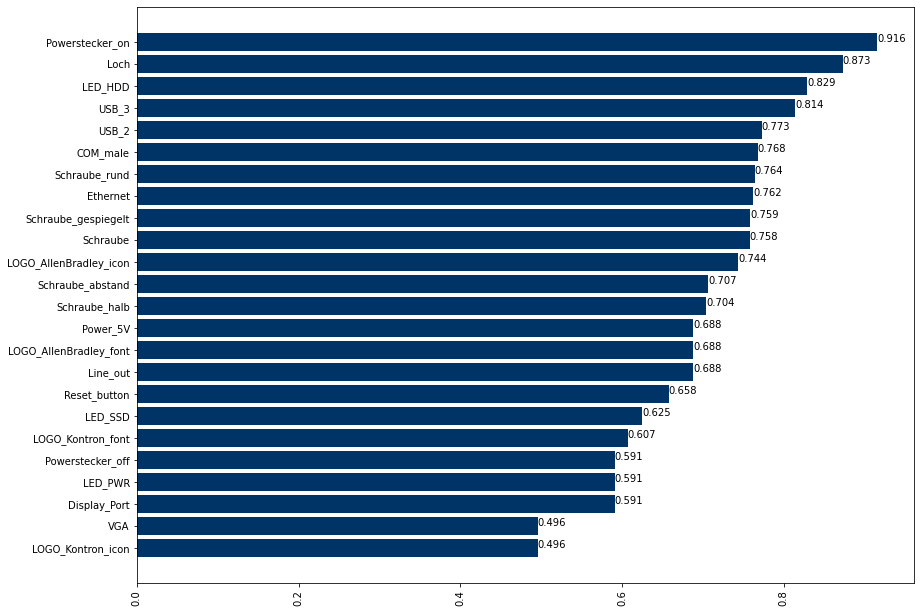

In [ ]:
import matplotlib.pyplot as plt

#F1_score = [ '%.3f' % elem for elem in F1_score ]
F1_score  = [ round(elem, 3) for elem in F1_score  ]


combined = list(zip(components_list,F1_score))
sorted_combined = sorted(combined, key=lambda x: x[1])
sorted_labels, sorted_numbers = zip(*sorted_combined)

fig = plt.figure()
ax = fig.add_axes([0,0,1.8,2])
ax.barh(sorted_labels, sorted_numbers, color="#003366")
plt.xticks(rotation=90)

for index, value in enumerate(sorted_numbers):
    plt.text(value, index,
             str(value))

plt.show()